<center> <h1>Data Analysis 2 </h1> </center>
<center> <h2>Zachary Gines</h2> </center>

In [236]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.factorplots import interaction_plot
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
import scipy.stats as stats
from statsmodels.stats.anova import anova_lm

## Data and Description

The goal of this analysis is to develop a regression model that predicts job profitability for a restoration company known as "Complete Restoration Utah". Each record in the dataset represents an individual restoration job completed by this company in Utah, with the response variable being "Gross Profit". The predictor variables will be job type, whether the company will be paying out of pocket or through insurance (refered to as "IsSelfPay"), year the house being restored built, and the estimator that worked on the job.

The data were obtained directly from the database of the software this company uses for scheduling and invoicing, "JobSight". A CSV file containing this dataset can be accessed [here](https://docs.google.com/spreadsheets/d/1JSqEguWOvyHefUJgsmFU6yz9Xd78DMXkQGiGokk-4Uk/edit?usp=sharing).

Understanding the factors that most strongly influence job profitability can help the company identify key areas for improvement and strategic focus. Additionally, being able to predict profitability for individual jobs enables the business to forecast performance with greater confidence.

The central research question guiding this analysis is:

“What characteristics best predict job profitability, and how accurately can these variables be used to forecast future profit?”

By answering this question, the analysis aims to help business leaders for this restoration company make more informed, data-driven decisions that enhance financial outcomes and operational efficiency.

## Summary Statisics

In [291]:
profit = pd.read_csv("JobProfitability.csv", delimiter = ',')

profit = profit.drop('JobId', axis=1)
profit.head()

,GrossProfit,JobType,IsSelfPay,YearBuilt,EstimatorUserId,EstimatorName
0,9400.31,Water,0,1974.0,26.0,Lucas Collier
1,3018.74,Water,1,1977.0,26.0,Lucas Collier
2,2176.64,Reconstruction,0,1995.0,26.0,Lucas Collier
3,2002.39,Reconstruction,0,1971.0,26.0,Lucas Collier
4,1017.27,Water,0,1998.0,26.0,Lucas Collier


In [292]:
profit.describe()

,GrossProfit,IsSelfPay,YearBuilt,EstimatorUserId
count,5056.000000,5056.000000,4704.000000,5055.000000
mean,4552.479502,0.366891,1997.985544,74.532938
std,10965.357485,0.482004,21.109503,84.522028
min,-395109.470000,0.000000,1850.000000,2.000000
25%,1022.602500,0.000000,1987.000000,27.000000
50%,2294.025000,0.000000,2001.000000,39.000000
75%,5183.937500,1.000000,2015.000000,60.000000
max,193312.870000,1.000000,2025.000000,283.000000


One thing that stands out here is the GrossProfit column. With an average of 4552.48 and a standard deviation of 10,965.36, it seems like there is a huge amount of variability in job profitability, which may make it hard to develop accurate predicitons. However, the max value of 193,312.87 is over 17 standard deviations above the mean, and the min value of -395,109.47 is nearly 37 standard deviations away from the mean, so we definitely have some massive outliers here that are impacting the variability.

## Response Variable Analysis

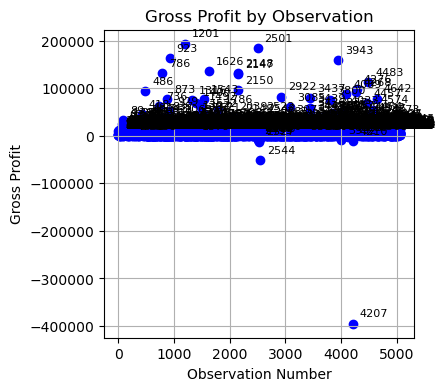

In [293]:
# Create scatter plot using the index
plt.figure(figsize=(4, 4))
plt.scatter(profit.index, profit['GrossProfit'], color='blue')

# Add labels to each point
for i in profit.index:
    plt.annotate(i, (i, profit.loc[i, 'GrossProfit']),
                 textcoords="offset points", xytext=(5,5), ha='left', fontsize=8)

# Add titles and labels
plt.title('Gross Profit by Observation')
plt.xlabel('Observation Number')
plt.ylabel('Gross Profit')
plt.grid(True)
plt.show()

In [294]:
# Select specific rows by index
profit.loc[4207]

GrossProfit           -395109.47
JobType                    Flood
IsSelfPay                      0
YearBuilt                    NaN
EstimatorUserId              2.0
EstimatorName      Jerry Pennock
Name: 4207, dtype: object

As noted earlier, there seems to be some extreme outliers in Gross Profit, so I decided to take a look at this right away. From this plot, it seems clear right away that the job 4207 is an extreme outlier. After looking into it a little more, this data point seems to be data entry error (the owner of the company entered the expeses for his pickleball court as a job with negative profit, so this doesn't reflect a real job). With that knowledge, I went ahead and removed this observation from the data set.

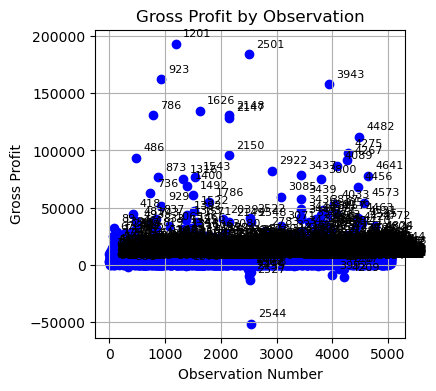

In [295]:
profit = profit[~profit.index.isin([4207])]

# Reset index just to be safe
profit = profit.reset_index(drop=True)

# Create scatter plot using the index
plt.figure(figsize=(4, 4))
plt.scatter(profit.index, profit['GrossProfit'], color='blue')

# Add labels to each point
for i in profit.index:
    plt.annotate(i, (i, profit.loc[i, 'GrossProfit']),
                 textcoords="offset points", xytext=(5,5), ha='left', fontsize=8)

# Add titles and labels
plt.title('Gross Profit by Observation')
plt.xlabel('Observation Number')
plt.ylabel('Gross Profit')
plt.grid(True)
plt.show()

After removing observatoin 4207, there are still several observations far away from the mean, but not so drastically that they should be removed immediately. This is something we can revisit as we check each of the model assumptions.

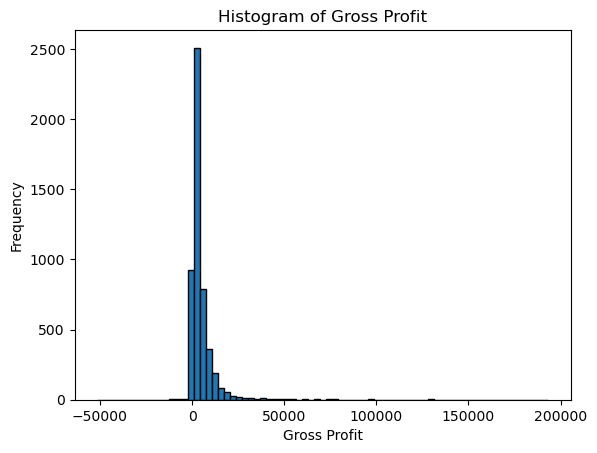

In [296]:
plt.hist(profit['GrossProfit'], bins=75, edgecolor = 'black') 
plt.xlabel("Gross Profit")
plt.ylabel("Frequency")
plt.title("Histogram of Gross Profit")
plt.show()

From this histogram alone there seems to be some right skew to the data, but in an effort to keep the model simple, we will hold off on a transformation at this point.

## Continuous Predictor Analysis

In [297]:
profit[profit['YearBuilt'].isnull()]

,GrossProfit,JobType,IsSelfPay,YearBuilt,EstimatorUserId,EstimatorName
53,1909.27,Water,0,NaN,26.0,Lucas Collier
228,2559.94,Mitigation,0,NaN,26.0,Lucas Collier
237,3096.67,Water,1,NaN,26.0,Lucas Collier
373,6452.80,Reconstruction,0,NaN,26.0,Lucas Collier
379,11623.19,Reconstruction,0,NaN,26.0,Lucas Collier
...,...,...,...,...,...,...
4712,1440.08,Sewer Loss,0,NaN,39.0,Quade Bunker
4748,2610.94,Fire,1,NaN,39.0,Quade Bunker
4781,1363.01,Fire,0,NaN,39.0,Quade Bunker
4961,366.50,Mold,1,NaN,194.0,Julian Galarza


One thing to note with the "YearBuilt" column is that there are a lot of null values, either because the user didn't care to enter a year built or the home owner didn't know the year the house was built. According to the business, it's most likely the former. Because it seems totally random, I'll start by imputing these missing values with the overall median "YearBuilt".

In [298]:
profit['YearBuilt'] = profit['YearBuilt'].fillna(profit['YearBuilt'].median())

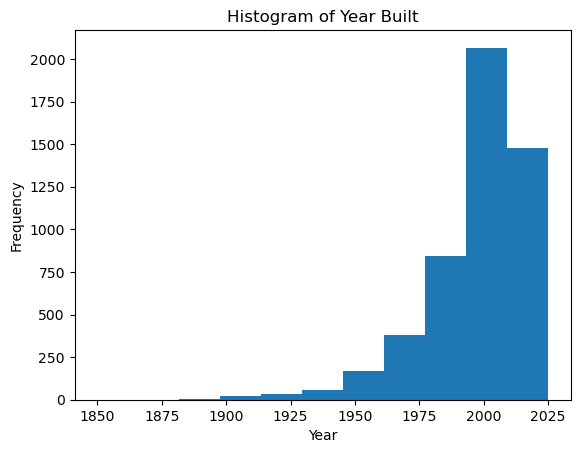

In [299]:
plt.hist(profit['YearBuilt'], bins=11) 
plt.xlabel("Year")
plt.ylabel("Frequency")
plt.title("Histogram of Year Built")
plt.show()

There is definitely a left skew to the year of the house, which isn't surprising as we would expect there to be more newer houses than old. This data should be transformed now 

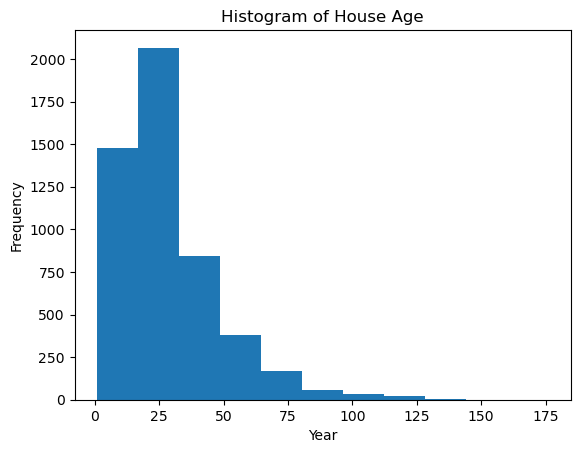

In [300]:
profit['HomeAge'] = 2026 - profit['YearBuilt']

plt.hist(profit['HomeAge'], bins=11) 
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.title("Histogram of Home Age")
plt.show()

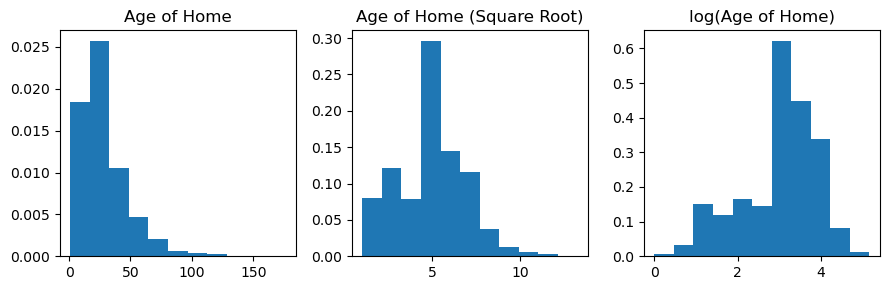

In [302]:
age_sqrt_trans = np.sqrt(profit['HomeAge'])
age_log_trans = np.log(profit['HomeAge'])

def hist_Y(variable, bin_size, ax, title):
    ax.hist(variable, density = True, bins = bin_size)
    ax.set_title(title)

fig, axes = plt.subplots(1, 3, figsize = (9, 3))
hist_Y(profit['HomeAge'], 11, axes[0], 'Age of Home') 
hist_Y(age_sqrt_trans, 11, axes[1], 'Age of Home (Square Root)')
hist_Y(age_log_trans, 11, axes[2], 'log(Age of Home)')
fig.tight_layout()
plt.show()

profit['HomeAgeTrans'] = age_log_trans

Rather than dealing with left skewed data, I decided to alter the data from the year the home was built to the age of the house to get right skewed data, which I found was easier to apply transformations to. I looked at both the square root of home age and the log of home age and found that a log transformation seemed to make a more normal distribution, so I decided to continue with that transformation.

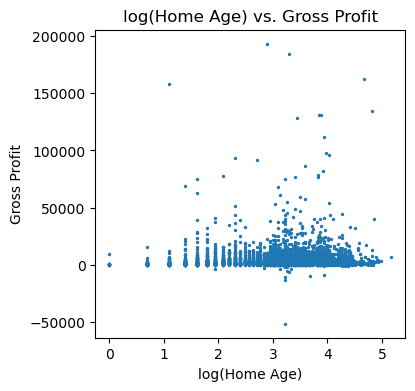

In [304]:
fig = plt.figure(figsize = (4, 4))
plt.scatter(x = profit['HomeAgeTrans'], 
            y = profit['GrossProfit'], 
            s = 2)
plt.ylabel("Gross Profit")
plt.xlabel("log(Home Age)")
plt.title("log(Home Age) vs. Gross Profit")
plt.show()

In [307]:
print('Correlation Coefficient:', profit['HomeAgeTrans'].corr(profit['GrossProfit']))

Correlation Coefficient: 0.09953353407905821


Looking at the scatterplot of gross profit vs. log(home age), there doesn't seem to be any linear correlation here. The correlation coefficient supports this, showing a very weak positive linear correlation. Because home age is the only continuous predictor, there won't be any issue with multicollinearity between continuous predictors.

## Categorical Predictors Analysis

In [308]:
profit['JobType'].value_counts()

JobType
Mitigation        2015
Water             1438
Reconstruction     547
Mold               362
Flood              206
Sewer Loss         189
Fire               145
Other              137
Trauma              16
Name: count, dtype: int64

In [309]:
16 / 5056 * 100

0.31645569620253167

In [310]:
137 / 5056 * 100

2.709651898734177

With the "Trauma" level for the JobType factor having very few observations (less than 1% of all rows are "Trauma"), any estimates from this level will have very wide standard errors and be generally unstable and unreliable. I think this group should be combined with the "Other" category to make for more stable estimates. The next lowest is "Other" which accounts for over 100 observations and about 3% of the data, so this and all other levels with more observations should be okay. Additionally, "Mitigation" and "Flood" represent the same job type, so those will need to be combined as well.

In [311]:
# Combine Trauma into Other
profit['JobType'] = profit['JobType'].replace({'Trauma': 'Other'})
profit['JobType'] = profit['JobType'].replace({'Flood': 'Mitigation'})

# Optional: check counts again
print(profit['JobType'].value_counts())

JobType
Mitigation        2221
Water             1438
Reconstruction     547
Mold               362
Sewer Loss         189
Other              153
Fire               145
Name: count, dtype: int64


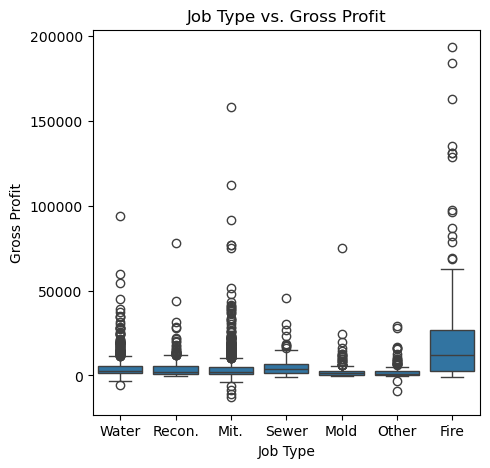

In [339]:
profit['JobType'] = profit['JobType'].replace({
    'Reconstruction': 'Recon.',
    'Mitigation': 'Mit.',
    'Sewer Loss': 'Sewer'
})
                       
plt.figure(figsize = (5,5))
sns.boxplot(x = 'JobType',
            y = 'GrossProfit',
            data = profit)
plt.xlabel('Job Type')
plt.ylabel('Gross Profit')
plt.title("Job Type vs. Gross Profit")
plt.show()

Looking at box plots for each level of Job Type, the median value of gross profit for each level is pretty clsoe to the overall mean of gross profit, other than perhaps "Fire", which seems like it's a bit higher than the others. Most of the levels also seem like they are left skewed, so some transformations may be necessary here. There also seems to be some outliers within these levels, especially for the other level. "Mitigation" and "Fire" seem to have the most variablity, which makes sense for mitigation given this level has the most observations. Overall, there may be some significance with the job type predictor due to "Fire" having a higher median than the others.

The median values for both Utah and other states seem to have roughly the same center with fairly normal shapes. Perhaps surprisingly, there is less variation in the other states group than there is in the Utah group. This may be due to the fact that there are more observations in the Utah group than the other states group. Overall, I'm not sure there is significance in this predictor based on the box plots.

In [313]:
profit['IsSelfPay'].value_counts()

IsSelfPay
0    3200
1    1855
Name: count, dtype: int64

There seems to be a sufficient number of rows of both jobs where the customer is paying with (0) and without insurance (1).

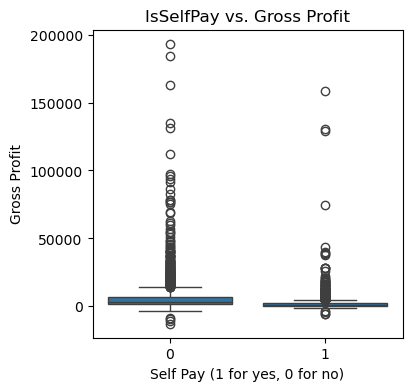

In [340]:
plt.figure(figsize = (4,4))
sns.boxplot(x = 'IsSelfPay',
            y = 'GrossProfit',
            data = profit)
plt.xlabel('Self Pay (1 for yes, 0 for no)')
plt.ylabel('Gross Profit')
plt.title("IsSelfPay vs. Gross Profit")
plt.show()

Both levels seem to be centered around the same point with relatively equal variability. Both seem to be left skewed, so a transformation may be needed here. Without any real difference in center between these two levels, I don't know how significant this predictor will be.

In [315]:
profit['EstimatorUserId'] = profit['EstimatorUserId'].astype('Int64')

est_summary = (
    profit.groupby(['EstimatorUserId', 'EstimatorName'], dropna=False)
    .size()
    .reset_index(name='NumJobs')
    .sort_values('NumJobs', ascending=False)
)

print(est_summary)

    EstimatorUserId       EstimatorName  NumJobs
3                27         Greg Prusak     1665
7                60    Jeffrey Peterson      859
4                39        Quade Bunker      668
11              283       Weston Clouse      625
2                26       Lucas Collier      496
6                53  Christian Martinez      305
10              194      Julian Galarza      177
9                78       Boyd Thatcher      126
1                20         Dan Goodwin       87
8                75          Todd Adams       21
5                46      Glenny P David       17
0                 2       Jerry Pennock        8
12             <NA>                 NaN        1


In [316]:
8 / 5056 * 100

0.15822784810126583

In [317]:
87 / 5056 * 100

1.720727848101266

The table above shows the list of estimators that have been on a job in this dataset. For the purposes of this first table, I have left both the Estimator Name and Estimtor Id in for reference on which Id corresponds to which estimator, however for the rest of the analysis, I will be using the id as the levels for this predictor. The bottom 3 estimators have been on very few jobs (just over 1% combined), so I think it makes sense to combine these, as well as the one job with no estimator, into an "Other" category to reduce the variability of our estimates by having levels with so few observations. All other estimators have enough jobs that there shouldn't be a problem.

In [318]:
profit['EstimatorUserId'] = (
    profit['EstimatorUserId']
    .astype(str)
    .replace({'2': 'Other', '46': 'Other', '75': 'Other', '<NA>': 'Other'})
)

profit['EstimatorUserId'].value_counts()

EstimatorUserId
27       1665
60        859
39        668
283       625
26        496
53        305
194       177
78        126
20         87
Other      47
Name: count, dtype: int64

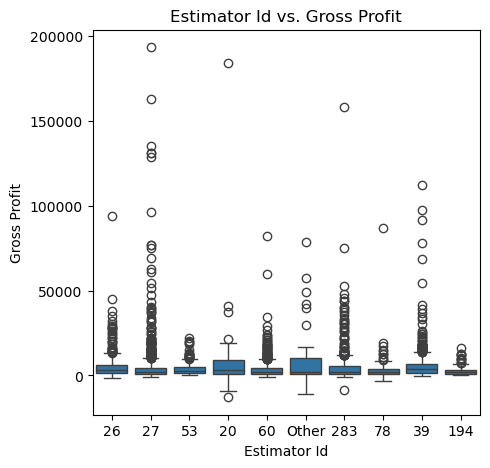

In [341]:
plt.figure(figsize = (5,5))
sns.boxplot(x = 'EstimatorUserId',
            y = 'GrossProfit',
            data = profit)
plt.xlabel('Estimator Id')
plt.ylabel('Gross Profit')
plt.title("Estimator Id vs. Gross Profit")
plt.show()

The median values for all estimators seems relatively equal. Some definitely have more variability than otheres, and estimator 20 has two points that seem like outliers, along with potentially estimator 78 and 283. Again, the data are left skewed, so a transformation may be needed here as well.

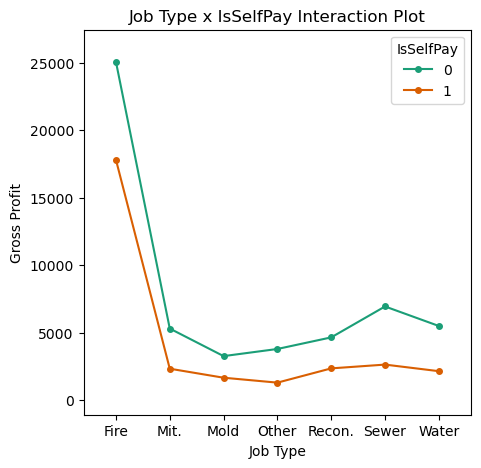

In [342]:
fig, ax = plt.subplots(figsize = (5, 5))
fig = interaction_plot(x = profit["JobType"],
                       trace = profit["IsSelfPay"],
                       response = profit["GrossProfit"],
                       colors = ["#1b9e77", "#d95f02"],
                       ms = 8,  # marker size
                       ax = ax)
ax.set_xlabel('Job Type')
ax.set_ylabel('Gross Profit')
plt.title("Job Type x IsSelfPay Interaction Plot")
ax.legend(title = 'IsSelfPay')

The slope doest seem to change much for the two different levels of "IsSelfPay" between job types, so I don't believe an interaction is necessary here.

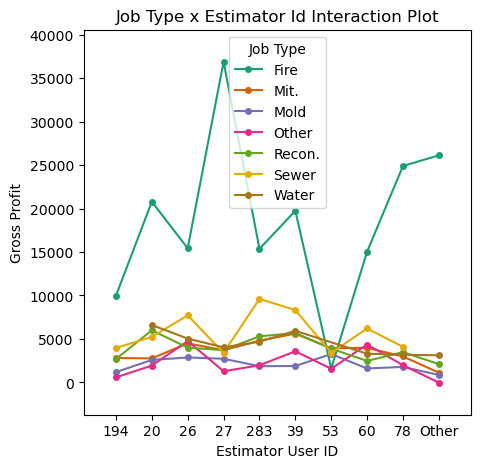

In [343]:
fig, ax = plt.subplots(figsize = (5, 5))
fig = interaction_plot(x = profit["EstimatorUserId"],
                       trace = profit["JobType"],
                       response = profit["GrossProfit"],
                       colors = ["#1b9e77", "#d95f02", "#7570b3", "#e7298a", "#66a61e", "#e6ab02", "#a6761d"],
                       ms = 8,  # marker size
                       ax = ax)
ax.set_xlabel('Estimator User ID')
ax.set_ylabel('Gross Profit')
plt.title("Job Type x Estimator Id Interaction Plot")
ax.legend(title = 'Job Type')

The slopes for each job type across estimators seems to change pretty dramatically. I think the model will benefit from having an interaction between estimator and job type. This makes sense in a business context as well, as different estimators will likely have different evaluations for each job type.

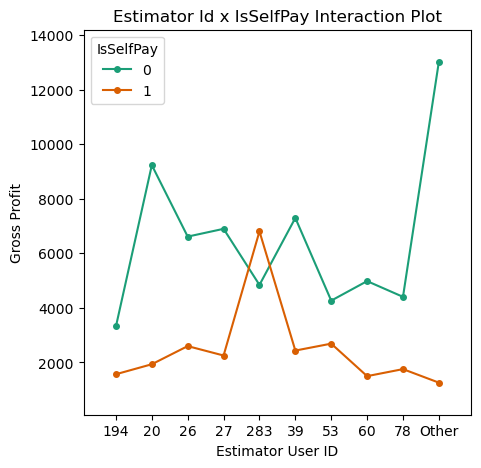

In [344]:
fig, ax = plt.subplots(figsize = (5, 5))
fig = interaction_plot(x = profit["EstimatorUserId"],
                       trace = profit["IsSelfPay"],
                       response = profit["GrossProfit"],
                       colors = ["#1b9e77", "#d95f02"],
                       ms = 8,  # marker size
                       ax = ax)
ax.set_xlabel('Estimator User ID')
ax.set_ylabel('Gross Profit')
plt.title("Estimator Id x IsSelfPay Interaction Plot")
ax.legend(title = 'IsSelfPay')

The slope definitely seems to change for the levels of "IsSelfPay" among different estimators, so an interaction between estimator and "IsSelfPay" would likely improve our model.

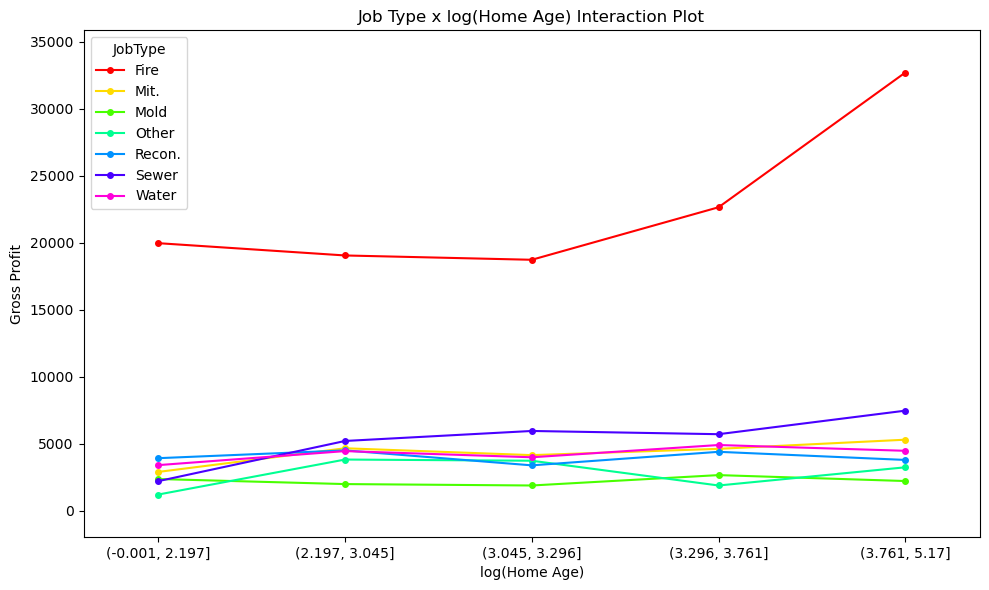

In [346]:
# Bin HomeAgeTrans into 5 quantiles
profit['HomeAgeTrans_bin'] = pd.qcut(profit['HomeAgeTrans'], q=5, duplicates='drop')

# Convert intervals to strings for plotting
profit['HomeAgeTrans_bin_str'] = profit['HomeAgeTrans_bin'].astype(str)

fig, ax = plt.subplots(figsize=(10,6))
interaction_plot(
    x=profit['HomeAgeTrans_bin_str'],
    trace=profit['JobType'],
    response=profit['GrossProfit'],
    ms=8,
    ax=ax
)

ax.set_xlabel('log(Home Age)')
ax.set_ylabel('Gross Profit')
plt.title("Job Type x log(Home Age) Interaction Plot")
plt.tight_layout()
plt.show()


While most of the job types have relatively similar slopes across log(home age), the "Fire" and "Trauma" types differe significantly. I think an interaction would be beneficial here.

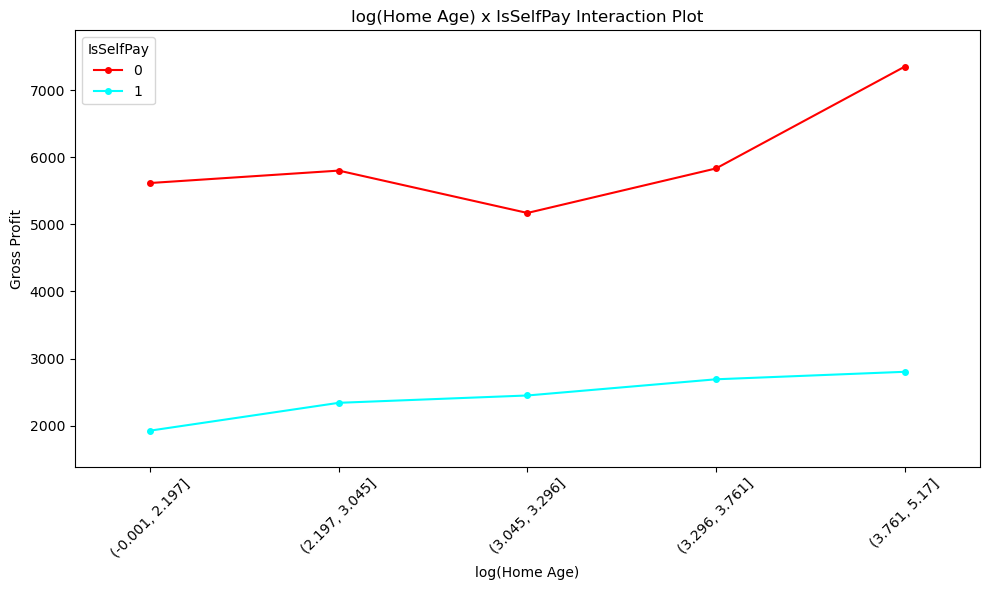

In [348]:
fig, ax = plt.subplots(figsize=(10,6))
interaction_plot(
    x=profit['HomeAgeTrans_bin_str'],
    trace=profit['IsSelfPay'],
    response=profit['GrossProfit'],
    ms=8,
    ax=ax
)

ax.set_xlabel('log(Home Age)')
ax.set_ylabel('Gross Profit')
plt.xticks(rotation=45)
plt.title("log(Home Age) x IsSelfPay Interaction Plot")
plt.tight_layout()
plt.show()

The interaction plot between log(home age) and "IsSelfPay" doesn't show too drastic of a difference between slopes, so I don't believe an interaction is necessary here.

Overall, it seems that our model could benefit from interactions between Job Type and Estimator Id, IsSelfPay and Estimator Id, and Job Type and log(Home Age).

In [349]:
profit_dummy = pd.get_dummies(profit, columns = ['JobType', 'IsSelfPay', 'EstimatorUserId'])

y = profit_dummy['GrossProfit']

# Make sure for each of the categorical predictors, you leave one of the levels out of the 
# model. This will be your baseline level
X = sm.add_constant(profit_dummy[['HomeAgeTrans', 
                                  'JobType_Fire', 'JobType_Mit.', 'JobType_Mold', 'JobType_Recon.', 'JobType_Sewer', 'JobType_Water',
                                  'IsSelfPay_0',
                                  'EstimatorUserId_194', 'EstimatorUserId_20', 'EstimatorUserId_26', 'EstimatorUserId_27', 'EstimatorUserId_283',
                                  'EstimatorUserId_39', 'EstimatorUserId_53', 'EstimatorUserId_60', 'EstimatorUserId_78']]
                   .apply(lambda col: col.astype(int) if col.dtype == bool else col))

mod = sm.OLS(y, X)
res = mod.fit()

profit['residuals'] = res.resid
profit['fittedvalues'] = res.fittedvalues
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            GrossProfit   R-squared:                       0.161
Model:                            OLS   Adj. R-squared:                  0.158
Method:                 Least Squares   F-statistic:                     56.95
Date:                Thu, 23 Oct 2025   Prob (F-statistic):          1.37e-177
Time:                        14:55:20   Log-Likelihood:                -52954.
No. Observations:                5054   AIC:                         1.059e+05
Df Residuals:                    5036   BIC:                         1.061e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -1134.1911   1506.300     -0.753      0.452   -4087.194    1818.812
HomeAgeTrans          509.1094    152.694      3.334      0.001     209.763     808.456
JobType_Fire         2.028e+04   1010.072     20.074      0.000    1.83e+04    2.23e+04
JobType_Mit.         1404.3825    733.218      1.915      0.056     -33.045    2841.810
JobType_Mold          131.4083    837.867      0.157      0.875   -1511.175    1773.992
JobType_Recon.        863.6177    798.464      1.082      0.279    -701.719    2428.955
JobType_Sewer        2397.6839    941.809      2.546      0.011     551.329    4244.039
JobType_Water        1188.2156    740.482      1.605      0.109    -263.451    2639.882
IsSelfPay_0          2917.4410    275.949     10.572      0.000    2376.461    3458.421
EstimatorUserId_194  -905.4266   1437.141     -0.630      0.529   -3722.847    1911.994
EstimatorUserId_20    497.4698   1565.415      0.318      0.751   -2571.425    3566.365
EstimatorUserId_26   1036.3494   1330.559      0.779      0.436   -1572.125    3644.823
EstimatorUserId_27   1225.7433   1294.266      0.947      0.344   -1311.580    3763.067
EstimatorUserId_283   179.3769   1325.422      0.135      0.892   -2419.027    2777.781
EstimatorUserId_39   1598.4369   1316.618      1.214      0.225    -982.708    4179.581
EstimatorUserId_53   -117.0320   1376.588     -0.085      0.932   -2815.744    2581.680
EstimatorUserId_60   -110.3159   1307.554     -0.084      0.933   -2673.691    2453.059
EstimatorUserId_78   -841.0535   1486.325     -0.566      0.572   -3754.896    2072.789
==============================================================================
Omnibus:                     7358.089   Durbin-Watson:                   1.907
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3327195.935
Skew:                           8.650   Prob(JB):                         0.00
Kurtosis:                     127.501   Cond. No.                         114.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

From an initial look at this model, it seems like estimator is not a significant predictor. I'm guessing this will be left out of the model in the variable selection process. It also seems like the intervals for each job type are very wide, sometimes even a $3000 range, so while these seem significant, I'm not sure how much value there will be in the predictions of this model. But we will see!

## Assumptions Analysis (Cursory Check)

### Xs vs. Y Are Linear  

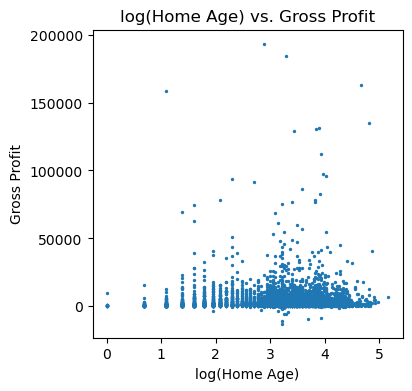

In [350]:
fig = plt.figure(figsize = (4, 4))
plt.scatter(x = profit['HomeAgeTrans'], 
y = profit['GrossProfit'], 
s = 2)
plt.ylabel("Gross Profit")
plt.xlabel("log(Home Age)")
plt.title("log(Home Age) vs. Gross Profit")
plt.show()

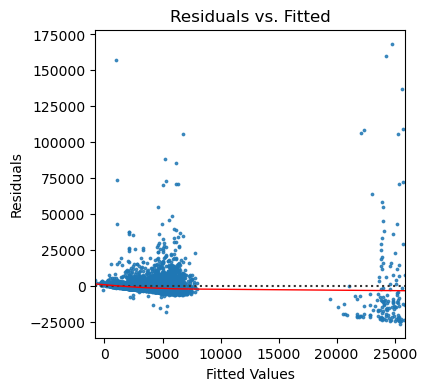

In [351]:
fig = plt.figure(figsize = (4, 4))
sns.residplot(x = profit['fittedvalues'], 
              y = profit['residuals'],
              lowess = True,
              scatter_kws = {'s': 3},
              line_kws = {'color': 'red', 'lw': 1})
plt.title("Residuals vs. Fitted")
plt.ylabel("Residuals")
plt.xlabel("Fitted Values")
plt.show()

It doesn't seem that any line would better fit the scatterplot data than a linear trend line, and the line in the residuals vs. fitted plot is very straight. This assumption is met.

### Residuals are normally distributed and centered at zero

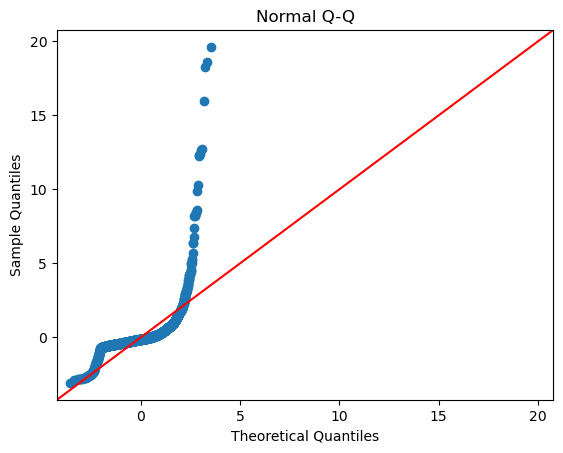

In [352]:
sm.qqplot(profit['residuals'], 
          line = '45', 
          fit = True)
plt.title("Normal Q-Q")

plt.show()

From an initial look at this assumption, it's clear that the residuals are not normally distributed. A transfomration will have to be applied here. After exploring some possible transformations, the best one I found was a log transformation of the response variable.

In [353]:
inv_trans = np.log(profit['GrossProfit'] + np.abs(profit['GrossProfit'].min()) + 1)
profit['GrossProfitTrans'] = inv_trans

In [354]:
profit_dummy = pd.get_dummies(profit, columns = ['JobType', 'IsSelfPay', 'EstimatorUserId'])

y = profit_dummy['GrossProfitTrans']

# Make sure for each of the categorical predictors, you leave one of the levels out of the 
# model. This will be your baseline level
X = sm.add_constant(profit_dummy[['HomeAgeTrans', 
                                  'JobType_Fire', 'JobType_Mit.', 'JobType_Mold', 'JobType_Recon.', 'JobType_Sewer', 'JobType_Water',
                                  'IsSelfPay_0',
                                  'EstimatorUserId_194', 'EstimatorUserId_20', 'EstimatorUserId_26', 'EstimatorUserId_27', 'EstimatorUserId_283',
                                  'EstimatorUserId_39', 'EstimatorUserId_53', 'EstimatorUserId_60', 'EstimatorUserId_78']]
                   .apply(lambda col: col.astype(int) if col.dtype == bool else col))

mod = sm.OLS(y, X)
res = mod.fit()

profit['residuals_trans'] = res.resid
profit['fittedvalues_trans'] = res.fittedvalues
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       GrossProfitTrans   R-squared:                       0.170
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                     60.56
Date:                Thu, 23 Oct 2025   Prob (F-statistic):          1.54e-188
Time:                        14:55:56   Log-Likelihood:                -860.79
No. Observations:                5054   AIC:                             1758.
Df Residuals:                    5036   BIC:                             1875.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   9.4137      0.050    187.177      0.000       9.315       9.512
HomeAgeTrans            0.0226      0.005      4.428      0.000       0.013       0.033
JobType_Fire            0.5706      0.034     16.920      0.000       0.505       0.637
JobType_Mit.            0.0647      0.024      2.641      0.008       0.017       0.113
JobType_Mold            0.0045      0.028      0.160      0.873      -0.050       0.059
JobType_Recon.          0.0494      0.027      1.852      0.064      -0.003       0.102
JobType_Sewer           0.1336      0.031      4.247      0.000       0.072       0.195
JobType_Water           0.0689      0.025      2.786      0.005       0.020       0.117
IsSelfPay_0             0.1561      0.009     16.939      0.000       0.138       0.174
EstimatorUserId_194    -0.0075      0.048     -0.157      0.875      -0.102       0.087
EstimatorUserId_20     -0.0859      0.052     -1.643      0.100      -0.188       0.017
EstimatorUserId_26      0.0856      0.044      1.927      0.054      -0.001       0.173
EstimatorUserId_27      0.0707      0.043      1.636      0.102      -0.014       0.155
EstimatorUserId_283     0.0275      0.044      0.621      0.535      -0.059       0.114
EstimatorUserId_39      0.1073      0.044      2.440      0.015       0.021       0.193
EstimatorUserId_53      0.0399      0.046      0.867      0.386      -0.050       0.130
EstimatorUserId_60      0.0272      0.044      0.623      0.534      -0.058       0.113
EstimatorUserId_78     -0.0169      0.050     -0.340      0.734      -0.114       0.080
==============================================================================
Omnibus:                     6400.446   Durbin-Watson:                   1.934
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         13961468.348
Skew:                          -5.931   Prob(JB):                         0.00
Kurtosis:                     260.213   Cond. No.                         114.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

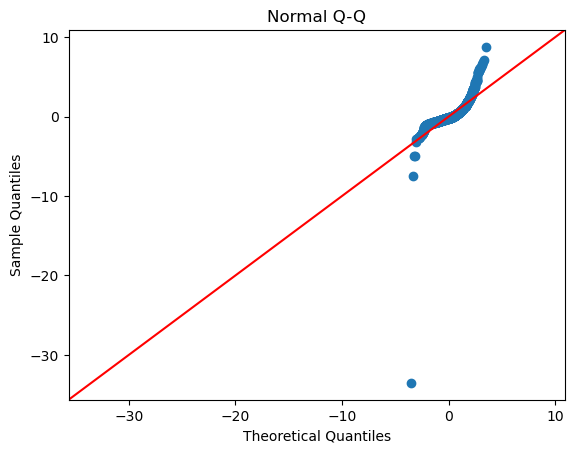

In [355]:
sm.qqplot(profit['residuals_trans'], 
          line = '45', 
          fit = True)
plt.title("Normal Q-Q")

plt.show()

In [356]:
min_idx = profit['residuals_trans'].idxmin()
profit.loc[[min_idx]]

,GrossProfit,JobType,IsSelfPay,YearBuilt,EstimatorUserId,EstimatorName,HomeAge,HomeAgeTrans,HomeAgeTrans_bin,HomeAgeTrans_bin_str,residuals,fittedvalues,GrossProfitTrans,residuals_trans,fittedvalues_trans
2527,-12808.53,Mit.,0,2001.0,20,Dan Goodwin,25.0,3.218876,"(3.045, 3.296]","(3.045, 3.296]",-18132.392228,5323.862228,0.0,-9.621234,9.621234


After applying the transformation, it looks like there is one residual that is very far away from all the other residuals. I identified this point as observation 2544. After speaking with the company, this was a job that was created before invoicing was put in place, so gross profit was calculated differently than it is now. The company advised that I remove this data point, as it no longer reflects accurately.

In [357]:
profit = profit[~profit.index.isin([2544])]

In [358]:
profit = profit.drop('GrossProfitTrans', axis=1)
profit = profit.drop('residuals_trans', axis=1)
profit = profit.drop('fittedvalues_trans', axis=1)

In [359]:
inv_trans = np.log(profit['GrossProfit'] + np.abs(profit['GrossProfit'].min()) + 1)
profit['GrossProfitTrans'] = inv_trans

In [360]:
profit_dummy = pd.get_dummies(profit, columns = ['JobType', 'IsSelfPay', 'EstimatorUserId'])

y = profit_dummy['GrossProfitTrans']

# Make sure for each of the categorical predictors, you leave one of the levels out of the 
# model. This will be your baseline level
X = sm.add_constant(profit_dummy[['HomeAgeTrans', 
                                  'JobType_Fire', 'JobType_Mit.', 'JobType_Mold', 'JobType_Recon.', 'JobType_Sewer', 'JobType_Water',
                                  'IsSelfPay_0',
                                  'EstimatorUserId_194', 'EstimatorUserId_20', 'EstimatorUserId_26', 'EstimatorUserId_27', 'EstimatorUserId_283',
                                  'EstimatorUserId_39', 'EstimatorUserId_53', 'EstimatorUserId_60', 'EstimatorUserId_78']]
                   .apply(lambda col: col.astype(int) if col.dtype == bool else col))

mod = sm.OLS(y, X)
res = mod.fit()

profit['residuals_trans'] = res.resid
profit['fittedvalues_trans'] = res.fittedvalues
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       GrossProfitTrans   R-squared:                       0.170
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                     60.56
Date:                Thu, 23 Oct 2025   Prob (F-statistic):          1.54e-188
Time:                        14:56:03   Log-Likelihood:                -860.79
No. Observations:                5054   AIC:                             1758.
Df Residuals:                    5036   BIC:                             1875.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   9.4137      0.050    187.177      0.000       9.315       9.512
HomeAgeTrans            0.0226      0.005      4.428      0.000       0.013       0.033
JobType_Fire            0.5706      0.034     16.920      0.000       0.505       0.637
JobType_Mit.            0.0647      0.024      2.641      0.008       0.017       0.113
JobType_Mold            0.0045      0.028      0.160      0.873      -0.050       0.059
JobType_Recon.          0.0494      0.027      1.852      0.064      -0.003       0.102
JobType_Sewer           0.1336      0.031      4.247      0.000       0.072       0.195
JobType_Water           0.0689      0.025      2.786      0.005       0.020       0.117
IsSelfPay_0             0.1561      0.009     16.939      0.000       0.138       0.174
EstimatorUserId_194    -0.0075      0.048     -0.157      0.875      -0.102       0.087
EstimatorUserId_20     -0.0859      0.052     -1.643      0.100      -0.188       0.017
EstimatorUserId_26      0.0856      0.044      1.927      0.054      -0.001       0.173
EstimatorUserId_27      0.0707      0.043      1.636      0.102      -0.014       0.155
EstimatorUserId_283     0.0275      0.044      0.621      0.535      -0.059       0.114
EstimatorUserId_39      0.1073      0.044      2.440      0.015       0.021       0.193
EstimatorUserId_53      0.0399      0.046      0.867      0.386      -0.050       0.130
EstimatorUserId_60      0.0272      0.044      0.623      0.534      -0.058       0.113
EstimatorUserId_78     -0.0169      0.050     -0.340      0.734      -0.114       0.080
==============================================================================
Omnibus:                     6400.446   Durbin-Watson:                   1.934
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         13961468.348
Skew:                          -5.931   Prob(JB):                         0.00
Kurtosis:                     260.213   Cond. No.                         114.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

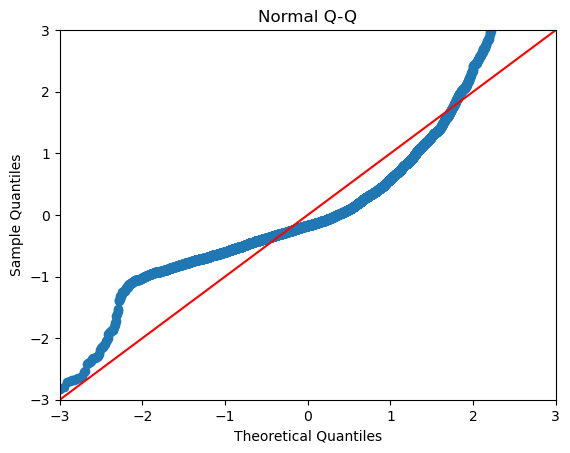

In [361]:
sm.qqplot(profit['residuals_trans'], 
          line = '45', 
          fit = True)
plt.title("Normal Q-Q")

plt.xlim(-3, 3)
plt.ylim(-3, 3)

plt.show()

While this has improved the assumption, it's still clear that the assumption has not been met. I recall from Simple Linear Regression that transformations can be applied to the predictor variable as well, I'm not sure if that applies in Multiple Linear Regression too or how you would go about that, but that would be the next thing I try.

### Xs vs. Y Are Linear (After Transformation)

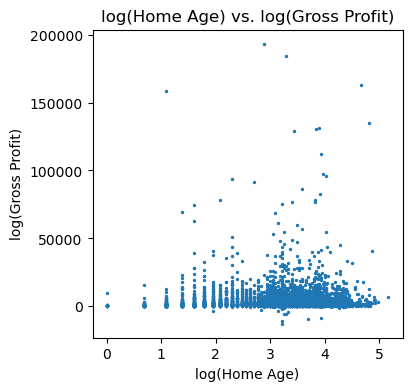

In [362]:
fig = plt.figure(figsize = (4, 4))
plt.scatter(x = profit['HomeAgeTrans'], 
y = profit['GrossProfit'], 
s = 2)
plt.ylabel("log(Gross Profit)")
plt.xlabel("log(Home Age)")
plt.title("log(Home Age) vs. log(Gross Profit)")
plt.show()

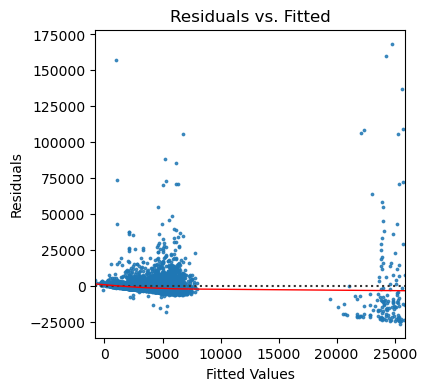

In [363]:
fig = plt.figure(figsize = (4, 4))
sns.residplot(x = profit['fittedvalues'], 
              y = profit['residuals'],
              lowess = True,
              scatter_kws = {'s': 3},
              line_kws = {'color': 'red', 'lw': 1})
plt.title("Residuals vs. Fitted")
plt.ylabel("Residuals")
plt.xlabel("Fitted Values")
plt.show()

The linearity assumption seems to hold true after the transformation.

### The residuals have constant variance across all values of x

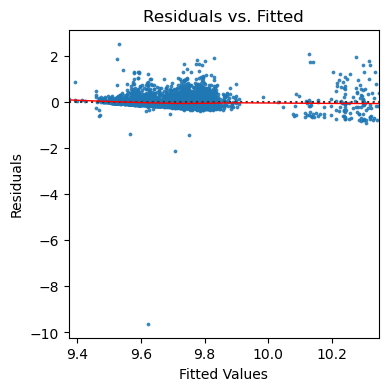

In [364]:
fig = plt.figure(figsize = (4, 4))
sns.residplot(x = profit['fittedvalues_trans'], 
              y = profit['residuals_trans'],
              lowess = True,
              scatter_kws = {'s': 3},
              line_kws = {'color': 'red', 'lw': 1})
plt.title("Residuals vs. Fitted")
plt.ylabel("Residuals")
plt.xlabel("Fitted Values")
plt.show()

There doesn't appear to be any funneling shape with the Residuals vs. Fitted plot. I think this assumption has been met.

### No Influential Points

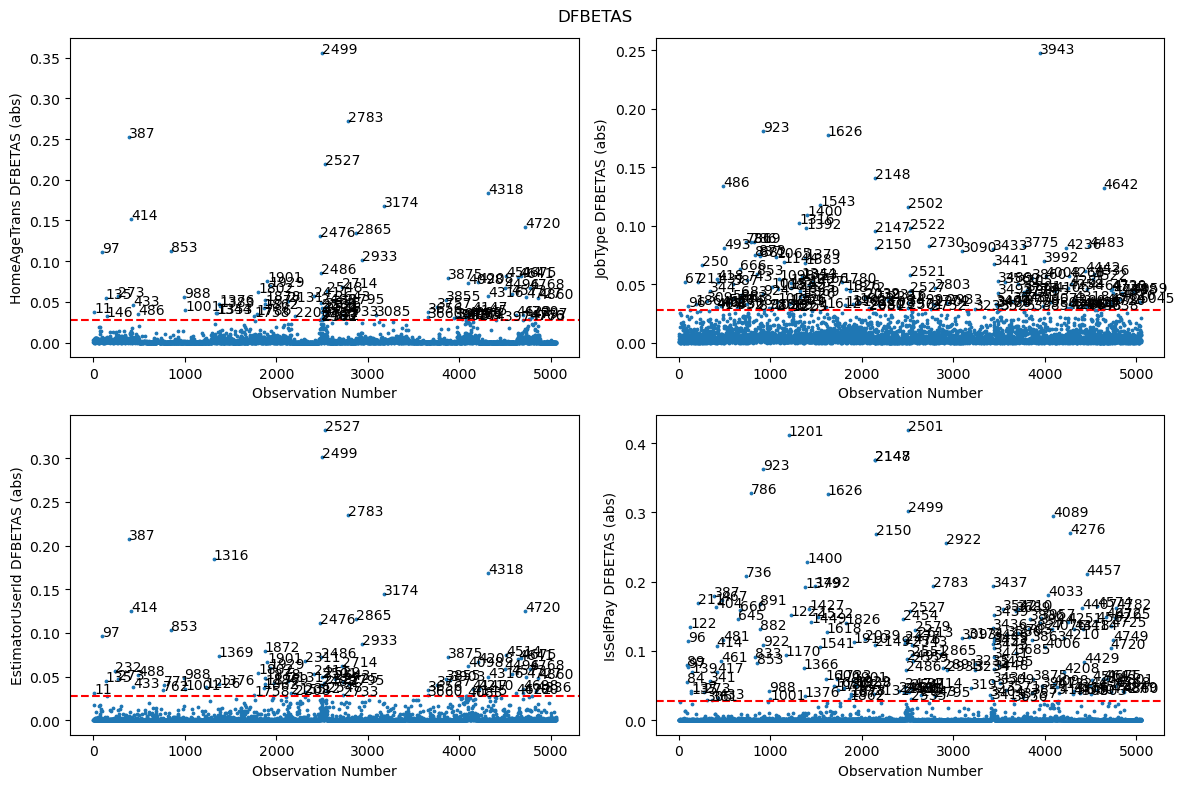

In [124]:
def plot_dfbetas(column, ax, label_level = 2 / np.sqrt(len(profit))):
    idx = profit.columns.get_loc(column)
    profit['dfbetas_' + column] = res.get_influence().dfbetas[:, idx]

    ax.set_ylabel(column + " DFBETAS (abs)")
    ax.set_xlabel("Observation Number")
    ax.scatter(profit.index, np.abs(profit['dfbetas_' + column]), s = 3)
    ax.axhline(y = label_level, color = 'r', linestyle = 'dashed')

    # optional: label outliers
    outliers = profit[np.abs(profit['dfbetas_' + column]) > label_level]
    for i in list(outliers.index):
        ax.annotate(str(i), (i, np.abs(profit['dfbetas_' + column][i])))
    
fig, axes = plt.subplots(2, 2, figsize = (12, 8))
plt.suptitle("DFBETAS")
plot_dfbetas("HomeAgeTrans", axes[0, 0])
plot_dfbetas("JobType", axes[0, 1])
plot_dfbetas("EstimatorUserId", axes[1, 0])
plot_dfbetas("IsSelfPay", axes[1, 1])
fig.tight_layout()
plt.show()

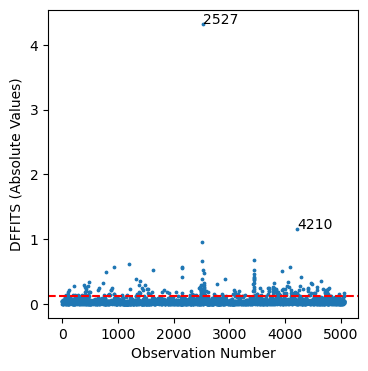

In [125]:
profit['dffits'] = res.get_influence().dffits[0]

fig, ax = plt.subplots(figsize = (4, 4))
ax.set_ylabel("DFFITS (Absolute Values)")
ax.set_xlabel("Observation Number")

# scatter + cutoff line
ax.scatter(profit.index,            
           np.abs(profit['dffits']), 
           s = 3)
ax.axhline(y = 2 * np.sqrt(len(res.params) / len(profit)), 
           color = 'r', 
           linestyle = 'dashed')

# Change the y_cutoff value to whatever number you want - all the
# points above that value will be labeled with their row number
y_cutoff_dffits = .9
outliers_dffits = profit[np.abs(profit['dffits']) > y_cutoff_dffits]
for i in outliers_dffits.index:
    ax.annotate(str(i), (i, np.abs(profit['dffits'][i])))                

plt.show()

In [126]:
profit.loc[2527]

GrossProfit                     -12808.53
JobType                              Mit.
IsSelfPay                               0
YearBuilt                          2001.0
EstimatorUserId                        20
EstimatorName                 Dan Goodwin
HomeAge                              25.0
HomeAgeTrans                     3.218876
HomeAgeTrans_bin           (3.045, 3.296]
HomeAgeTrans_bin_str       (3.045, 3.296]
residuals                   -17564.649972
fittedvalues                  4756.119972
GrossProfitTrans                      0.0
residuals_trans                 -9.621234
fittedvalues_trans               9.621234
dfbetas_HomeAgeTrans            -0.219132
dfbetas_JobType                 -0.044258
dfbetas_EstimatorUserId         -0.332248
dfbetas_IsSelfPay                0.157758
dffits                          -4.329471
Name: 2527, dtype: object

From the DFFITS plot, it seems our only real potential influential point is 2527, which does show up in our log(home age) plot and estimator id plot. After speaking to the company, this was a legitimate job with a particularly bad gross profit, so the observation should be kept in the model. This assumption has been met.

### No additional predictors required

This assumption is certainly not met. There are several predictors that would be very beneficial to have, the biggest one being the square footage of the home. However, because this data is not required to be input by the users and most users don't bother, less than 1% of the jobs have square footage reported, so it wasn't possible to use this predictor in the model. There are likely other predictors, too, that would be beneficial that we don't have data for (i.e., equipment used, technician hours, etc.).

### No Multicollinearity

Because I only have one continuous predictor in the model, I won't have to worry about multicollinearity. This assumption is met.

## Variable Selection

### Sequential Replacement

In [365]:
y = profit_dummy['GrossProfitTrans']
x = (profit_dummy[['HomeAgeTrans', 
                  'JobType_Fire', 'JobType_Mit.', 'JobType_Mold', 'JobType_Recon.', 'JobType_Sewer', 'JobType_Water',
                  'IsSelfPay_0',
                  'EstimatorUserId_194', 'EstimatorUserId_20', 'EstimatorUserId_26', 'EstimatorUserId_27', 'EstimatorUserId_283',
                  'EstimatorUserId_39', 'EstimatorUserId_53', 'EstimatorUserId_60', 'EstimatorUserId_78']]
                   .apply(lambda col: col.astype(int) if col.dtype == bool else col))

# Tell python which dummy variables belong to the same categorical variable:
feature_groups = [[0], [1, 2, 3, 4, 5, 6], [7], [8, 9, 10, 11, 12, 13, 14, 15, 16]]

seqrep_selection = SFS(LinearRegression(fit_intercept = True),
                       k_features = (1, len(feature_groups)), # defined above
                       forward = True,
                       floating = True,
                       scoring = 'neg_mean_squared_error',
                       feature_groups = feature_groups, # defined above
                       cv = 5)

seqrep = seqrep_selection.fit(x, y)

print('Sequential Replacement Stepwise Selection:', seqrep.k_feature_names_)

Sequential Replacement Stepwise Selection: ('HomeAgeTrans', 'JobType_Fire', 'JobType_Mit.', 'JobType_Mold', 'JobType_Recon.', 'JobType_Sewer', 'JobType_Water', 'IsSelfPay_0')


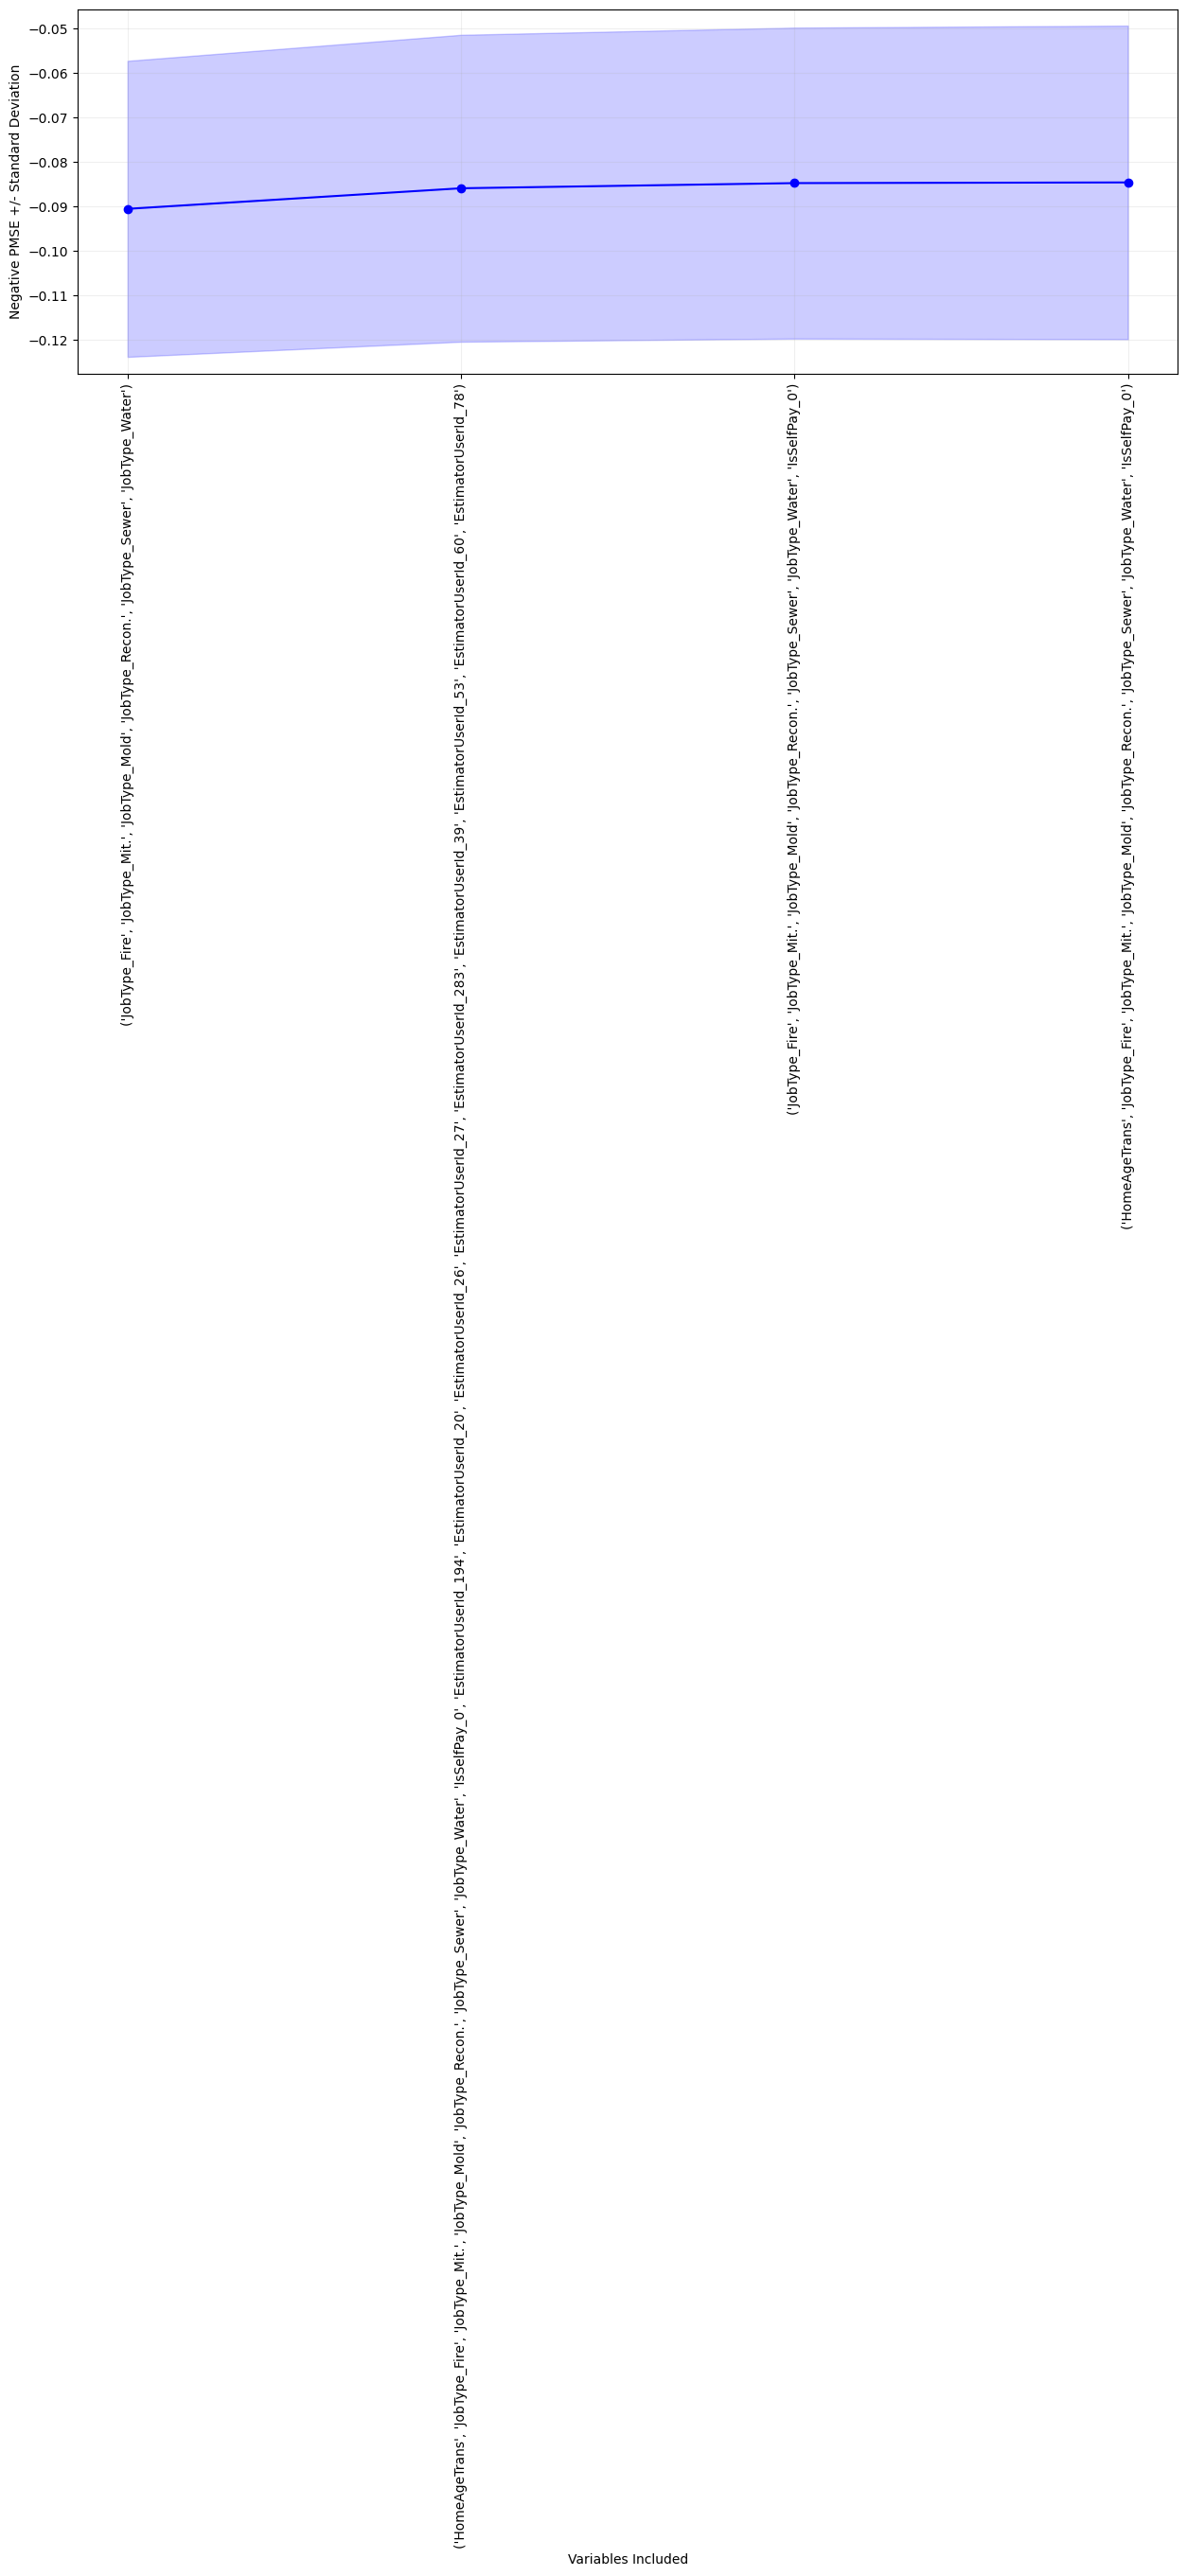

In [366]:
metric_dict = seqrep.get_metric_dict()
x_axis = sorted(metric_dict.keys())

metric_dict_sorted = dict(sorted(metric_dict.items(), key = lambda x: x[1]['avg_score']))

fig = plt.figure(figsize = (15, 5))
k_feat = metric_dict_sorted.keys()
k_feat_list = list(k_feat)
avg = [metric_dict_sorted[k]['avg_score'] for k in k_feat]

upper, lower = [], []
for k in k_feat:
    upper.append(metric_dict_sorted[k]['avg_score'] +
                 metric_dict_sorted[k]['std_dev'])
    lower.append(metric_dict_sorted[k]['avg_score'] -
                 metric_dict_sorted[k]['std_dev'])
    
plt.fill_between(x_axis,
                 upper,
                 lower,
                 alpha = 0.2,
                 color = 'blue',
                 lw = 1)

plt.plot(x_axis, avg, color = 'blue', marker = 'o')
plt.ylabel('Negative PMSE +/- Standard Deviation')
plt.xlabel('Variables Included')
plt.xticks(x_axis, 
           [str(metric_dict_sorted[k]['feature_names']) for k in k_feat_list], 
           rotation = 90)
plt.grid(alpha = 0.2)
plt.show()

In [367]:
# Code to see the next best models
seqrep_results = pd.DataFrame.from_dict(seqrep.get_metric_dict()).T
seqrep_results_sorted = seqrep_results.sort_values(by = 'avg_score', ascending = False)
seqrep_results_sorted.head(20)

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
3,"(0, 1, 2, 3, 4, 5, 6, 7)","[-0.06138460182048177, -0.06145348787493667, -...",-0.084532,"(HomeAgeTrans, JobType_Fire, JobType_Mit., Job...",0.045302,0.035246,0.017623
2,"(1, 2, 3, 4, 5, 6, 7)","[-0.0621493477100802, -0.06209155828807331, -0...",-0.084687,"(JobType_Fire, JobType_Mit., JobType_Mold, Job...",0.044925,0.034953,0.017477
4,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[-0.06390586336468634, -0.06213517157308179, -...",-0.085847,"(HomeAgeTrans, JobType_Fire, JobType_Mit., Job...",0.044342,0.0345,0.01725
1,"(1, 2, 3, 4, 5, 6)","[-0.07267836627286879, -0.07056815954972857, -...",-0.090475,"(JobType_Fire, JobType_Mit., JobType_Mold, Job...",0.042775,0.03328,0.01664


From the sequential replacement method, it seems that every number of predictors was roughly the same. To make the simplest model possible, we could select job type as our only predictor, but for the purposes of this project, based on this method, I would select the next best model that contains two predictors, which would be the model with job type and "IsSelfPay".

### LASSO

In [369]:
X = (profit_dummy[['HomeAgeTrans', 
                                  'JobType_Fire', 'JobType_Mit.', 'JobType_Mold', 'JobType_Recon.', 'JobType_Sewer', 'JobType_Water',
                                  'IsSelfPay_0',
                                  'EstimatorUserId_194', 'EstimatorUserId_20', 'EstimatorUserId_26', 'EstimatorUserId_27', 'EstimatorUserId_283',
                                  'EstimatorUserId_39', 'EstimatorUserId_53', 'EstimatorUserId_60', 'EstimatorUserId_78']]
                   .apply(lambda col: col.astype(int) if col.dtype == bool else col))

#Standardize continuous predictors ONLY
y = profit_dummy['GrossProfitTrans'].ravel()
variable_names = ['HomeAgeTrans']
scaler = StandardScaler().fit(X[variable_names])
X[variable_names] = scaler.transform(X[variable_names])

# Create a list of possible alphas
potential_alphas = np.logspace(-4, 2, 500)
LASSOCV_model = LassoCV(alphas = potential_alphas, 
                        cv = 5, 
                        random_state = 12345, 
                        max_iter = 10000, 
                        fit_intercept = True)

# Fit the model
LASSOCV_model.fit(X, y)

# Get the list of alphas and corresponding MSEs
alphas = LASSOCV_model.alphas_
pmse_means = np.mean(LASSOCV_model.mse_path_, axis = 1)
pmse_std_error = np.std(LASSOCV_model.mse_path_, 
                        axis = 1,
                        ddof = 1) / np.sqrt(5)  # 5-fold CV

# Find the alpha that minimizes MSE
alpha_index_min = np.argmin(pmse_means)
alpha_min = alphas[alpha_index_min]

# Find the MSE that is one standard error away from the minimum MSE
one_se_above_min = min(pmse_means) + pmse_std_error[alpha_index_min]

# Find the largetst alpha with MSE less than or equal to one_se_above_min
alpha_index_1se = np.where(pmse_means <= one_se_above_min)[0][0]
alpha_1se = alphas[alpha_index_1se]

print("Minimum alpha:", alpha_min)
print("One SE alpha:", alpha_1se)

C:\Users\zacha\AppData\Local\Temp\ipykernel_17144\2773064357.py:9: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y = profit_dummy['GrossProfitTrans'].ravel()


Minimum alpha: 0.0003573602246065788
One SE alpha: 100.0


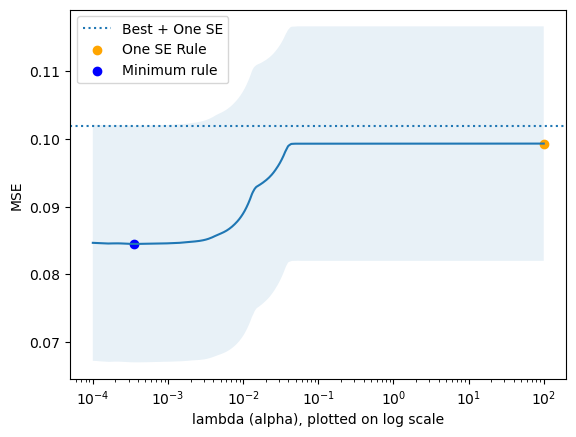

In [370]:
# Optional plot
plt.plot(alphas, 
         pmse_means)
plt.fill_between(alphas, 
                 pmse_means + pmse_std_error, 
                 pmse_means - pmse_std_error, 
                 alpha = 0.1)
plt.axhline(one_se_above_min, 
            linestyle = 'dotted', 
            label = 'Best + One SE')
plt.scatter([alpha_1se], 
            [pmse_means[alpha_index_1se]], 
            marker = 'o',
            color = 'orange', 
            label = 'One SE Rule')
plt.scatter([alpha_min],
            [pmse_means[alpha_index_min]],
            marker = 'o',
            color = 'blue',
            label = 'Minimum rule')
plt.legend()
plt.xscale('log')
plt.xlabel('lambda (alpha), plotted on log scale')
plt.ylabel('MSE')
plt.show()

In [371]:
# LASSO results with lambda within one SE of the mean
LASSO_1se = Lasso(alpha = alpha_1se,
                  fit_intercept = True)
LASSO_1se.fit(X, y)

# Get coefficients
print(list(zip(LASSO_1se.coef_, X)))

[(np.float64(0.0), 'HomeAgeTrans'), (np.float64(0.0), 'JobType_Fire'), (np.float64(-0.0), 'JobType_Mit.'), (np.float64(-0.0), 'JobType_Mold'), (np.float64(-0.0), 'JobType_Recon.'), (np.float64(0.0), 'JobType_Sewer'), (np.float64(0.0), 'JobType_Water'), (np.float64(0.0), 'IsSelfPay_0'), (np.float64(-0.0), 'EstimatorUserId_194'), (np.float64(-0.0), 'EstimatorUserId_20'), (np.float64(0.0), 'EstimatorUserId_26'), (np.float64(-0.0), 'EstimatorUserId_27'), (np.float64(0.0), 'EstimatorUserId_283'), (np.float64(0.0), 'EstimatorUserId_39'), (np.float64(-0.0), 'EstimatorUserId_53'), (np.float64(-0.0), 'EstimatorUserId_60'), (np.float64(-0.0), 'EstimatorUserId_78')]


In [372]:
# LASSO results with min(lambda)
LASSO_min = Lasso(alpha = alpha_min,
                  fit_intercept = True)
LASSO_min.fit(X, y)

# Get coefficients
print(list(zip(LASSO_min.coef_, X)))

[(np.float64(0.01981858917109515), 'HomeAgeTrans'), (np.float64(0.5084826199381963), 'JobType_Fire'), (np.float64(0.01866709057987206), 'JobType_Mit.'), (np.float64(-0.036304985627142024), 'JobType_Mold'), (np.float64(0.0), 'JobType_Recon.'), (np.float64(0.07850674845783903), 'JobType_Sewer'), (np.float64(0.021878140154526663), 'JobType_Water'), (np.float64(0.15595531054638995), 'IsSelfPay_0'), (np.float64(-0.02432633499232881), 'EstimatorUserId_194'), (np.float64(-0.09470278807167248), 'EstimatorUserId_20'), (np.float64(0.05473146977657855), 'EstimatorUserId_26'), (np.float64(0.04150226942405857), 'EstimatorUserId_27'), (np.float64(-0.0), 'EstimatorUserId_283'), (np.float64(0.07634652968487178), 'EstimatorUserId_39'), (np.float64(0.0063195989013819075), 'EstimatorUserId_53'), (np.float64(-0.0), 'EstimatorUserId_60'), (np.float64(-0.03317133360597296), 'EstimatorUserId_78')]


It seems like there's something wrong with my code for the LASSO method. When I look at the results within one SE of the mean, it suggests that I remove all variables from my model. When looking at the results with min(lambda), though, the model suggests keeping all of the predictors.

Based on these two methods, with one suggesting job type and "IsSelfPay" and the other suggesting all four predictors, I would end up choosing the model with only job type and "IsSelfPay", one reason being that I don't trust the results of the LASSO method, but the other being that the initial look at the model didn't support estimator id being included either, and the model is much simpler with log(home age) removed. Therefore I think that the best, simplest model would be the one using "Job Type" and "IsSelfPay".

In [373]:
profit_dummy = pd.get_dummies(profit, columns = ['JobType', 'IsSelfPay'])

y = profit_dummy['GrossProfitTrans']

# Make sure for each of the categorical predictors, you leave one of the levels out of the 
# model. This will be your baseline level
X = sm.add_constant(profit_dummy[['JobType_Fire', 'JobType_Mit.', 'JobType_Mold', 'JobType_Recon.', 'JobType_Sewer', 'JobType_Water',
                                  'IsSelfPay_0']]
                   .apply(lambda col: col.astype(int) if col.dtype == bool else col))

mod = sm.OLS(y, X)
res = mod.fit()

profit['residuals_simple'] = res.resid
profit['fittedvalues_simple'] = res.fittedvalues
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       GrossProfitTrans   R-squared:                       0.153
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     130.7
Date:                Thu, 23 Oct 2025   Prob (F-statistic):          2.48e-177
Time:                        14:58:30   Log-Likelihood:                -909.80
No. Observations:                5054   AIC:                             1836.
Df Residuals:                    5046   BIC:                             1888.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              9.5248      0.024    397.701      0.000       9.478       9.572
JobType_Fire       0.5711      0.034     16.906      0.000       0.505       0.637
JobType_Mit.       0.0683      0.024      2.808      0.005       0.021       0.116
JobType_Mold       0.0135      0.028      0.482      0.630      -0.041       0.069
JobType_Recon.     0.0568      0.027      2.131      0.033       0.005       0.109
JobType_Sewer      0.1439      0.032      4.554      0.000       0.082       0.206
JobType_Water      0.0841      0.025      3.397      0.001       0.036       0.133
IsSelfPay_0        0.1611      0.009     18.687      0.000       0.144       0.178
==============================================================================
Omnibus:                     6470.088   Durbin-Watson:                   1.906
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         14381002.472
Skew:                          -6.060   Prob(JB):                         0.00
Kurtosis:                     264.045   Cond. No.                         20.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Assumption Checks (In-Depth)

### Xs vs Y are linear

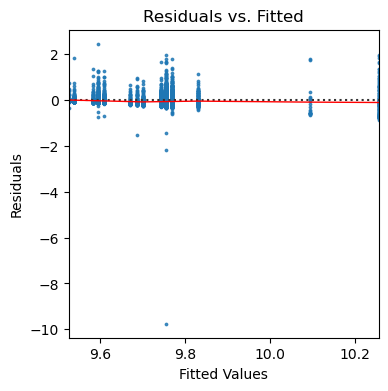

In [374]:
fig = plt.figure(figsize = (4, 4))
sns.residplot(x = profit['fittedvalues_simple'], 
              y = profit['residuals_simple'],
              lowess = True,
              scatter_kws = {'s': 3},
              line_kws = {'color': 'red', 'lw': 1})
plt.title("Residuals vs. Fitted")
plt.ylabel("Residuals")
plt.xlabel("Fitted Values")
plt.show()

Now that we are left with only categorical predictors, a scatter plot or partial regression plot doesn't make sense in this context. The residuals vs fitted values plot shows a very straight line, however, so this assumption is met.

### Residuals are independent

There is some potential for dependence here. One possibility could be if a single home had multiple restoration jobs done, those observations would be more closely related than restoration jobs from other homes, however if this is the case I would guess it's pretty rare. Another could be timing, if certain times of year produce more restoration jobs than others (maybe rainy seasons cause more floods, or summer has more fires than winter, etc.). I'm not sure if this is the case, but in a future model it may make sense to speak with an industry expert about both of these issues to see if this should be considered or not. Other than that, there isn't anything that jumps out as obviously causing dependence. I would say this assumption is met for now, but should be investigated further. 

### Residuals are normally distributed and centered at 0

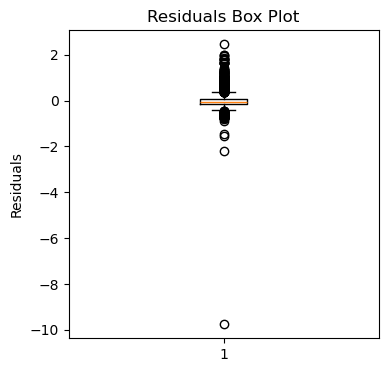

In [376]:
fig = plt.figure(figsize = (4, 4))
plt.boxplot(profit['residuals_simple'])
plt.ylabel("Residuals")
plt.title("Residuals Box Plot")
plt.show()

In [377]:
lowest_idx = profit['residuals_simple'].idxmin()
profit.loc[lowest_idx]

GrossProfit                  -12808.53
JobType                           Mit.
IsSelfPay                            0
YearBuilt                       2001.0
EstimatorUserId                     20
EstimatorName              Dan Goodwin
HomeAge                           25.0
HomeAgeTrans                  3.218876
HomeAgeTrans_bin        (3.045, 3.296]
HomeAgeTrans_bin_str    (3.045, 3.296]
residuals                -18132.392228
fittedvalues               5323.862228
GrossProfitTrans                   0.0
residuals_trans              -9.621234
fittedvalues_trans            9.621234
residuals_simple             -9.754213
fittedvalues_simple           9.754213
Name: 2527, dtype: object

There seems to be one residual that is very far away from all the other residuals. It seems that this residual is the same observation mentioned earlier, so it should be left in the model.

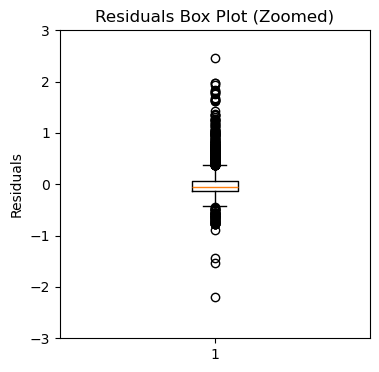

In [380]:
fig = plt.figure(figsize = (4, 4))
plt.boxplot(profit['residuals_simple'])
plt.ylabel("Residuals")
plt.title("Residuals Box Plot (Zoomed)")
plt.ylim(-3, 3)
plt.show()

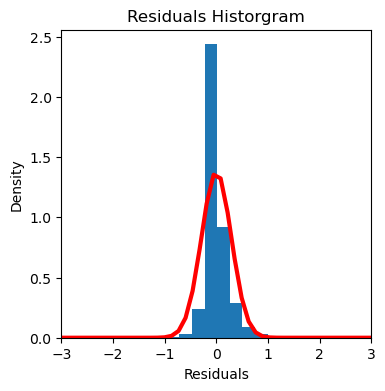

In [381]:
fig = plt.figure(figsize = (4, 4))

# plot histogram (density = True so that it's on the same scale as the normal distribution)
plt.hist(profit['residuals_simple'], 
         density = True, 
         bins = 50)
plt.xlabel("Residuals")
plt.ylabel("Density")

# calculate mean and standard deviation
mean = np.mean(profit['residuals_simple'])
sd = np.std(profit['residuals_simple'])

# generate x values to plot
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)

# plot normal distribution curve
plt.plot(x,
         stats.norm.pdf(x, mean, sd), 
         color = 'r',
         lw = 3)
plt.xlim(-3, 3)
plt.title("Residuals Historgram")
plt.show()

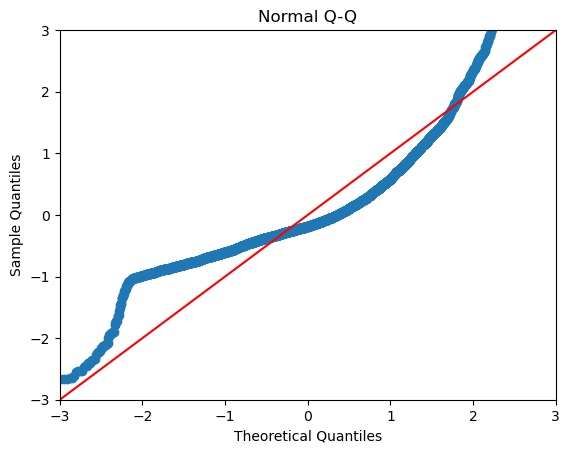

In [382]:
sm.qqplot(profit['residuals_simple'], 
          line = '45', 
          fit = True)
plt.title("Normal Q-Q")
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.show()

In [383]:
stats.shapiro(profit['residuals_simple'])

C:\Users\zacha\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5054.
  res = hypotest_fun_out(*samples, **kwds)


ShapiroResult(statistic=np.float64(0.6595934254077522), pvalue=np.float64(2.6738786314381885e-72))

The Q-Q plot still shows a very non-normal distribution for the residuals, and the shapiro-wilk test confirms this, although the box plot and histogram look pretty normal when ignoring the one residual that is far below the others, though you can still see some right skew here as well. I wonder how much this one residual is messing up the normality of the rest of the data, and if this point should be removed even if it is valid data. For now, I will consider this assumption not met.

### Constant variance among residuals

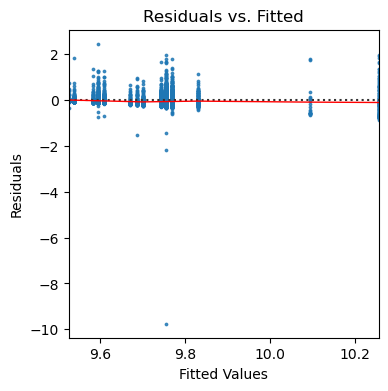

In [384]:
fig = plt.figure(figsize = (4, 4))
sns.residplot(x = profit['fittedvalues_simple'], 
              y = profit['residuals_simple'],
              lowess = True,
              scatter_kws = {'s': 3},
              line_kws = {'color': 'red', 'lw': 1})
plt.title("Residuals vs. Fitted")
plt.ylabel("Residuals")
plt.xlabel("Fitted Values")
plt.show()

There is no funneling shape to the residuals vs fitted values plot. This assumption is met.

### No Influential Points

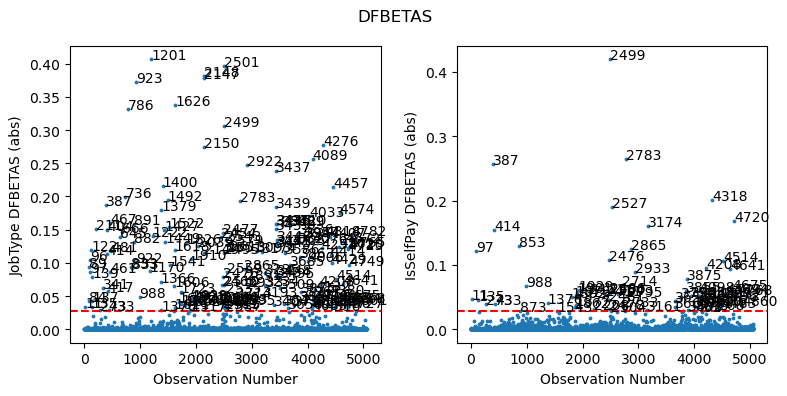

In [271]:
def plot_dfbetas(column, ax, label_level = 2 / np.sqrt(len(profit))):
    idx = profit.columns.get_loc(column)
    profit['dfbetas_' + column] = res.get_influence().dfbetas[:, idx]

    ax.set_ylabel(column + " DFBETAS (abs)")
    ax.set_xlabel("Observation Number")
    ax.scatter(profit.index, np.abs(profit['dfbetas_' + column]), s = 3)
    ax.axhline(y = label_level, color = 'r', linestyle = 'dashed')

    # optional: label outliers
    outliers = profit[np.abs(profit['dfbetas_' + column]) > label_level]
    for i in list(outliers.index):
        ax.annotate(str(i), (i, np.abs(profit['dfbetas_' + column][i])))
    
fig, axes = plt.subplots(1, 2, figsize = (8, 4))
plt.suptitle("DFBETAS")
plot_dfbetas("JobType", axes[0])
plot_dfbetas("IsSelfPay", axes[1])
fig.tight_layout()
plt.show()

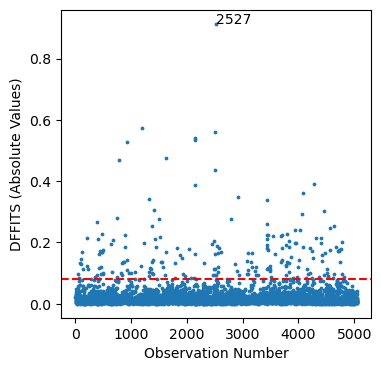

In [272]:
profit['dffits'] = res.get_influence().dffits[0]

fig, ax = plt.subplots(figsize = (4, 4))
ax.set_ylabel("DFFITS (Absolute Values)")
ax.set_xlabel("Observation Number")

# scatter + cutoff line
ax.scatter(profit.index,            
           np.abs(profit['dffits']), 
           s = 3)
ax.axhline(y = 2 * np.sqrt(len(res.params) / len(profit)), 
           color = 'r', 
           linestyle = 'dashed')

# Change the y_cutoff value to whatever number you want - all the
# points above that value will be labeled with their row number
y_cutoff_dffits = .9
outliers_dffits = profit[np.abs(profit['dffits']) > y_cutoff_dffits]
for i in outliers_dffits.index:
    ax.annotate(str(i), (i, np.abs(profit['dffits'][i])))                

plt.show()

Again observation 2527 shows up. I would consider this assumption to be met with the knowledge that observation 2527 shouldn't be removed from the model.

### No additional predictors required

This assumption is certainly not met. There are several predictors that would be very beneficial to have, the biggest one being the square footage of the home. However, because this data is not required to be input by the users and most users don't bother, less than 1% of the jobs have square footage reported, so it wasn't possible to use this predictor in the model. There are likely other predictors, too, that would be beneficial that we don't have data for (equipment used, technician hours, etc.).

### No multicollinearity

Because we have no continuous predictors, this assumption is not a concer for this model.

## Interaction Terms

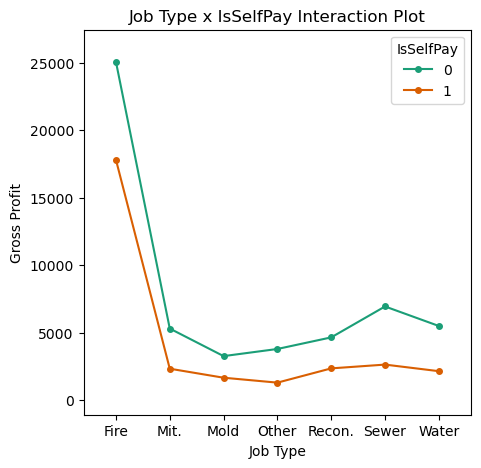

In [386]:
fig, ax = plt.subplots(figsize = (5, 5))
fig = interaction_plot(x = profit["JobType"],
                       trace = profit["IsSelfPay"],
                       response = profit["GrossProfit"],
                       colors = ["#1b9e77", "#d95f02"],
                       ms = 8,  # marker size
                       ax = ax)
ax.set_xlabel('Job Type')
ax.set_ylabel('Gross Profit')
plt.title("Job Type x IsSelfPay Interaction Plot")
ax.legend(title = 'IsSelfPay')

From our EDA, we determined that an interaction may make sense between job type and estimator id, "IsSelfPay" and estimator id, and job type and log(home age), but because we removed estimator id and log(home age) from the model, I'll only check if an interaction makes sense between job type and "IsSelfPay", however I don't expect a significant interaction because the interaction plot between job type and "IsSelfPay" showed perhaps the least evidence of an interaction of any of my interaction plots.

In [387]:
profit_dummy = pd.get_dummies(profit, columns = ['JobType', 'IsSelfPay'])

bool_cols = profit_dummy.select_dtypes(include='bool').columns
profit_dummy[bool_cols] = profit_dummy[bool_cols].astype(int)

job_types = profit['JobType'].unique()

int_list = []
for job_type in job_types:
    if job_type != 'Other':
        profit_dummy[job_type + '_IsSelfPay_1'] = profit_dummy['JobType_' + job_type] * profit_dummy['IsSelfPay_1']
        int_list.append(str(job_type + '_IsSelfPay_1'))

y = profit_dummy['GrossProfit']

baselines = ['JobType_Other', 'IsSelfPay_0']
X = sm.add_constant(
    profit_dummy[['JobType_Fire', 'JobType_Mit.', 'JobType_Mold', 'JobType_Recon.', 'JobType_Sewer', 'JobType_Water', 
                  'IsSelfPay_0'] 
                + int_list]
    .apply(lambda col: col.astype(int) if col.dtype == bool else col)
)

mod_int = sm.OLS(y, X)
res_int = mod_int.fit()
profit['residuals_int'] = res_int.resid
profit['fittedvalues_int'] = res_int.fittedvalues
res_int.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            GrossProfit   R-squared:                       0.156
Model:                            OLS   Adj. R-squared:                  0.154
Method:                 Least Squares   F-statistic:                     71.52
Date:                Thu, 23 Oct 2025   Prob (F-statistic):          3.35e-174
Time:                        15:00:20   Log-Likelihood:                -52970.
No. Observations:                5054   AIC:                         1.060e+05
Df Residuals:                    5040   BIC:                         1.061e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1287.2703   1017.391      1.265      0.206    -707.258    3281.798
JobType_Fire        2.128e+04   1236.035     17.218      0.000    1.89e+04    2.37e+04
JobType_Mit.        1513.1787    992.413      1.525      0.127    -432.383    3458.740
JobType_Mold        -528.9889   1226.724     -0.431      0.666   -2933.902    1875.924
JobType_Recon.       859.1508   1057.303      0.813      0.416   -1213.623    2931.925
JobType_Sewer       3150.2024   1239.951      2.541      0.011     719.360    5581.045
JobType_Water       1703.1595   1005.247      1.694      0.090    -267.562    3673.881
IsSelfPay_0         2495.0592   1402.376      1.779      0.075    -254.208    5244.326
Water_IsSelfPay_1   -853.8692   1482.049     -0.576      0.565   -3759.329    2051.591
Recon._IsSelfPay_1   197.8739   1630.936      0.121      0.903   -2999.471    3395.219
Mit._IsSelfPay_1    -480.6550   1452.764     -0.331      0.741   -3328.703    2367.393
Sewer_IsSelfPay_1  -1813.0119   1923.992     -0.942      0.346   -5584.872    1958.848
Mold_IsSelfPay_1     893.8533   1691.499      0.528      0.597   -2422.220    4209.927
Fire_IsSelfPay_1   -4765.4007   2507.821     -1.900      0.057   -9681.821     151.020
==============================================================================
Omnibus:                     7354.211   Durbin-Watson:                   1.892
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3289463.061
Skew:                           8.646   Prob(JB):                         0.00
Kurtosis:                     126.781   Cond. No.                         47.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [388]:
anova_lm(res, res_int)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,5046.0,4.241516e+02,0.0,NaN,NaN,NaN
1,5040.0,3.756112e+11,6.0,-3.756112e+11,-839.999999,1.0


The F test confirms what I hypothesised, the interaction is not significant (p-value = 1.0). We will continue with the model that does not include any interactions.

## Model Analysis

In [389]:
print('R-squared adjusted:', round(res.rsquared_adj, 4))

R-squared adjusted: 0.1523


The R-squared adjusted value indicates that this model explains about 15% of the variability in log(gross profit), which is not very much.

In [390]:
print("The test statistic for the F-test is", 
      round(res.fvalue, 2), 
      "and the corresponding p-value is",
      res.f_pvalue)

The test statistic for the F-test is 130.69 and the corresponding p-value is 2.476424400733913e-177


The F-test confirms that the model is significant (, which means that there is evidence of a statistically significant relationship between log(gross profit) and job type and "IsSelfPay".

In [278]:
rmse = np.sqrt(np.sum((profit['GrossProfitTrans'] - profit['fittedvalues_simple']) ** 2) / (len(profit) - 2))
print('RMSE (log-scale):', rmse)

RMSE (log-scale): 0.28975362606927735


In [280]:
mae = np.sum(np.abs(profit['GrossProfitTrans'] - profit['fittedvalues_simple'])) / (len(profit) - 2)
print('MAE (log-scale):', mae)

MAE (log-scale): 0.16671367814489826


In [281]:
print('log(gross profit) min:', profit['GrossProfitTrans'].min())
print('log(gross profit) max:', profit['GrossProfitTrans'].max())

log(gross profit) min: 0.0
log(gross profit) max: 12.236225446077071


On average, our model predictions for log(gross profit) are off by between 0.17 and 0.29 log-units. For a log(gross profit) range of $12.24, this seems like an acceptable level of error.

In [282]:
res.conf_int()

,0,1
const,9.477877,9.571781
JobType_Fire,0.504857,0.637304
JobType_Mit.,0.020612,0.115982
JobType_Mold,-0.041494,0.068521
JobType_Recon.,0.004546,0.109006
JobType_Sewer,0.081969,0.205890
JobType_Water,0.035564,0.132618
IsSelfPay_0,0.144188,0.177987


In [283]:
print(0.504857 - 0.081969, 0.637304 - 0.205890)

0.422888 0.43141399999999996


From our confidence intervals, we can see the effect of each of our levels relative to the baseline level. For job type, the baseline level was "Other". This means that job types of "Fire" make on average between 0.50 and 0.64 log-units more than "Other" job types. Mitigation jobs, reconstruction, sewer and water jobs all also make more than "Other" jobs, while mold jobs made on average between 0.04 log-units less than "Other" jobs, and 0.07 log-units more than "Other" jobs. Overall, it seems that fire jobs made more than any other job, with the next highest being sewer jobs. Fire jobs made on average between 0.42 and 0.43 log-units more than sewer jobs. Jobs in which the customer used insurance when paying also made on average between 0.14 and 0.18 log-units more than jobs where the customer paid themeselves. 

In [286]:
print('Test Statistics')
print(res.tvalues)
print('P-Values')
print(res.pvalues)

Test Statistics
const             397.700788
JobType_Fire       16.905887
JobType_Mit.        2.807822
JobType_Mold        0.481619
JobType_Recon.      2.131066
JobType_Sewer       4.553958
JobType_Water       3.397182
IsSelfPay_0        18.687438
dtype: float64
P-Values
const             0.000000e+00
JobType_Fire      2.068544e-62
JobType_Mit.      5.006930e-03
JobType_Mold      6.300977e-01
JobType_Recon.    3.313188e-02
JobType_Sewer     5.388516e-06
JobType_Water     6.861012e-04
IsSelfPay_0       2.091188e-75
dtype: float64


From the test statistics and p-values we can see that the only level that was not statistically significant was the mold job type. This means that both job type and "IsSelfPay" are significant predictors of log(gross profit). 

In [287]:
#Average log(gross profit) when the customer is paying with insurance for a mitigation job
pred = res.get_prediction([1, 0, 1, 0, 0, 0, 0, 1])
pred.summary_frame(alpha = 0.05).iloc[:, [0, 2, 3]]

,mean,mean_ci_lower,mean_ci_upper
0,9.754213,9.740624,9.767803


The average log(gross profit) for a mitigation job when a customer is not paying themselves is between 9.74 and 9.77 log units.

In [290]:
#Average log(gross profit) when the customer is paying with insurance for a mitigation job
pred = res.get_prediction([1, 1, 0, 0, 0, 0, 0, 0])
pred.summary_frame(alpha = 0.05).iloc[:, [0, 4, 5]]

,mean,obs_ci_lower,obs_ci_upper
0,10.09591,9.525387,10.666433


For a new fire job when a customer is paying themselves, the company can expect to make between 9.53 and 10.67 log units.

## Summary

The goal with this analysis was to use data that is available before a job has been completed to predict the gross profit of the job. Ultimlately, it was determined that the best model to predict gross profit used the job type and whether the customer was paying themselves or through insurance. Overall, the model was statistically significant, meaning that using job type and "IsSelfPay" leads to better predictions than simply refering to the mean of gross profit, however the model explains only ~15% of the variability in gross profit. This means that while there is a statistically significant relationship between gross profit and job type and "IsSelfPay", there may not be any real world application for this model without expanding to include other predictors, such as square footage or equpiment used, for example.